In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import load_npz

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, StandardScaler

# Save model
import joblib

In [2]:
# Load TF-IDF features
X_train = load_npz("train_features_tfidf.npz")
X_val = load_npz("val_features_tfidf.npz")
X_test = load_npz("test_features_tfidf.npz")

# Load labels
y_train = pd.read_csv("train_labels.csv")['medical_specialty']
y_val = pd.read_csv("val_labels.csv")['medical_specialty']
y_test = pd.read_csv("test_labels.csv")['medical_specialty']

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (1724, 5000) y_train: (1724,)
X_val: (370, 5000) y_val: (370,)
X_test: (370, 5000) y_test: (370,)


In [3]:
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"]
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=3,   # reduced for speed, increase if needed
    scoring="accuracy",
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


/Users/ayomahansani/Documents/Machine Learning - Dasun sir/Course Work/axora-medarchive-solution/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ayomahansani/Documents/Machine Learning - Dasun sir/Course Work/axora-medarchive-solution/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ayomahansani/Documents/Machine Learning - Dasun sir/Course Work/axora-medarchive-solution/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be rem

Best Parameters: {'C': 100, 'penalty': 'l2'}


/Users/ayomahansani/Documents/Machine Learning - Dasun sir/Course Work/axora-medarchive-solution/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ayomahansani/Documents/Machine Learning - Dasun sir/Course Work/axora-medarchive-solution/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ayomahansani/Documents/Machine Learning - Dasun sir/Course Work/axora-medarchive-solution/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be rem

Cross-Validation Scores: [0.78434783 0.78782609 0.7804878 ]
Mean CV Accuracy: 0.784220572640509


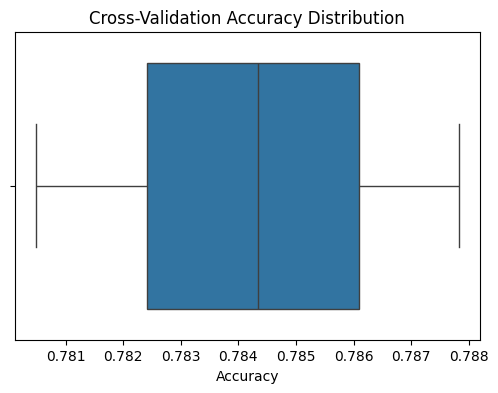

In [4]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring="accuracy")

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

plt.figure(figsize=(6,4))
sns.boxplot(x=cv_scores)
plt.title("Cross-Validation Accuracy Distribution")
plt.xlabel("Accuracy")
plt.show()


In [5]:
joblib.dump(best_model, "softmax_regression_model.pkl")
print("✅ Model saved as softmax_regression_model.pkl")


✅ Model saved as softmax_regression_model.pkl


In [6]:
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))
print("F1-score:", f1_score(y_test, y_pred, average="weighted"))

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7621621621621621
Precision: 0.7944094530587976
Recall: 0.7621621621621621
F1-score: 0.773016846151484

Classification Report:
                             precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.92      0.95      0.94       109
      ENT - Otolaryngology       0.91      0.71      0.80        14
          Gastroenterology       0.89      0.83      0.86        41
     Hematology - Oncology       0.53      0.67      0.59        15
                Nephrology       1.00      0.50      0.67        10
                 Neurology       0.61      0.64      0.62        47
              Neurosurgery       0.41      0.45      0.43        20
   Obstetrics / Gynecology       0.96      0.75      0.84        32
             Ophthalmology       0.80      0.73      0.76        11
                Orthopedic       0.74      0.70      0.72        57
     Pediatrics - Neonatal       0.29      0.67      0.40         3
   Psychiatry / Psychology       0.75      0

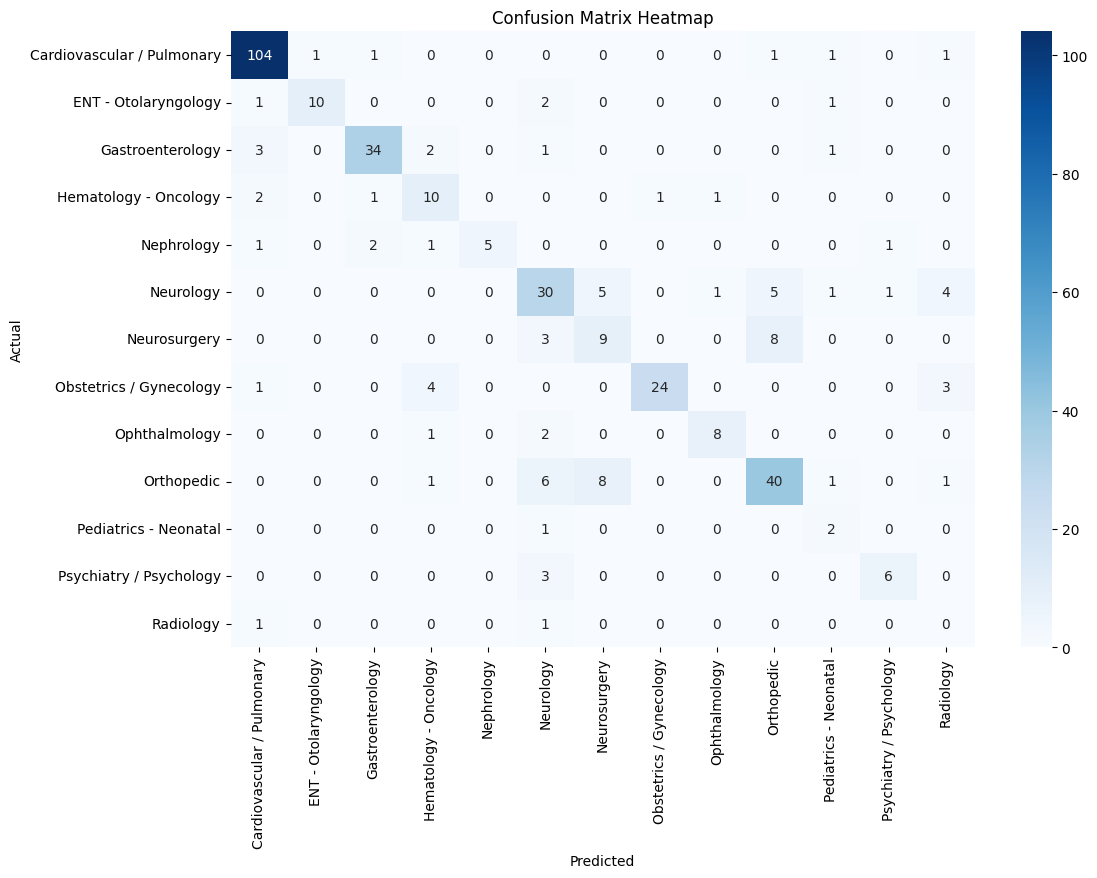

In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()


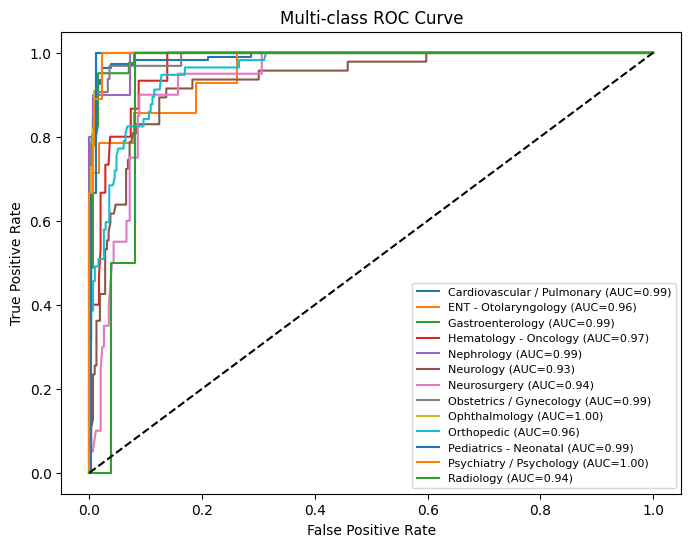

In [9]:
# Binarize labels
y_bin = label_binarize(y_test, classes=best_model.classes_)
n_classes = y_bin.shape[1]

# Predict probabilities
y_score = best_model.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{best_model.classes_[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right", fontsize=8)
plt.show()
